In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import numpy as np


CSV_FILE = "gemini-2.5-flash.csv"
#CSV_FILE = "gemini-2.5-pro.csv"

MODEL = CSV_FILE.replace(".csv","")
GENERAL_DATAFRAME_PATH = "results.csv"
pipelines_lst = [
                 "baseline",
                 "bm25", 
                 "dense",
                 "hybrid"
                ]

try:
    df = pd.read_csv(CSV_FILE)
    print(f"Loaded {len(df)} records from {CSV_FILE}")
except FileNotFoundError:
    print("CSV file not found. Run main.py")


Loaded 560 records from gemini-2.5-flash.csv


In [2]:
df.head()
#df['score'] = df['score'].astype(bool)
#df = df.rename(columns={'score': 'correct'})
#df = df.drop(columns=['Unnamed: 0'])
#df.to_csv(CSV_FILE,index=False)
#df[df['pipeline'] == 'Baseline (Zero-shot)'].count()

,question_number,pipeline,correct,predicted,ground_truth,quote,source,latency,run_timestamp
0,1,Baseline (Zero-shot),False,ERROR,C,No quote provided,NaN,17.386941,2025-12-02 16:08:38
1,2,Baseline (Zero-shot),False,ERROR,C,No quote provided,NaN,9.267145,2025-12-02 16:08:38
2,3,Baseline (Zero-shot),False,ERROR,B,No quote provided,NaN,10.708548,2025-12-02 16:08:38
3,4,Baseline (Zero-shot),True,D,D,No quote provided,NaN,4.656242,2025-12-02 16:08:38
4,5,Baseline (Zero-shot),False,ERROR,C,No quote provided,NaN,7.404452,2025-12-02 16:08:38


 #### PREPROCESS: Clean Data for Plotting

In [3]:
df = df.rename(columns={'correct': 'score'})

df['score'] = df['score'].fillna(0).astype(int)
df['score'] = df['score'].astype(int)

if 'run_timestamp' in df.columns:
    df['run_timestamp'] = pd.to_datetime(df['run_timestamp'])

df.loc[92:93,:]

,question_number,pipeline,score,predicted,ground_truth,quote,source,latency,run_timestamp
92,23,BM25 RAG,1,C,C,"Unlike prior methods (Yen et al., 2024),REFRAG...","2509.01092v2.pdf, Page: 1",3.996469,2025-12-02 16:16:26
93,24,BM25 RAG,1,C,C,The main objectives are to align the encoder a...,"2509.01092v2.pdf, Page: 3",3.713129,2025-12-02 16:16:26


#### Análisis de precisión para el nuevo dataset

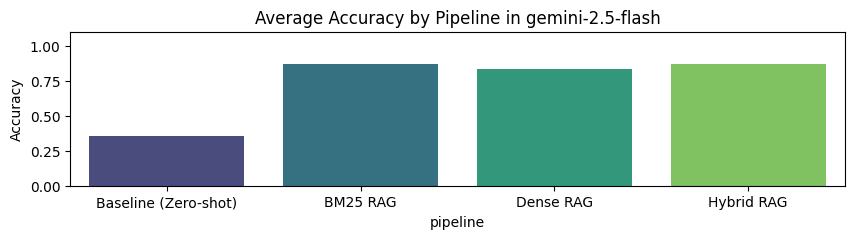

In [4]:
plt.figure(figsize=(10, 2)) 

sns.barplot(
    data=df, 
    x="pipeline", 
    y="score", 
    hue="pipeline", 
    palette="viridis",
    errorbar=None
)

plt.title(f"Average Accuracy by Pipeline in {MODEL}")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)

plt.show()

In [5]:
if not os.path.exists(GENERAL_DATAFRAME_PATH):
    rows = ['Baseline (Zero-shot)', 'Dense RAG', 'BM25 RAG', 'Hybrid RAG']
    cols = [
        'pro_acc', 'pro_count', 
        'flash_acc', 'flash_count'
    ]
    general_df = pd.DataFrame(0.0, index=rows, columns=cols)

    general_df['last_run_timestamp'] = pd.Timestamp("2000-01-01")
else:
    general_df = pd.read_csv(GENERAL_DATAFRAME_PATH)
    
general_df

,pipeline,pro_acc,pro_count,flash_acc,flash_count,last_run_timestamp
0,Baseline (Zero-shot),0.642857,1.0,0.328571,1.0,2025-12-02 21:42:00
1,Dense RAG,0.847826,1.0,0.828571,1.0,2025-12-02 21:42:00
2,BM25 RAG,0.906475,1.0,0.871429,1.0,2025-12-02 21:42:00
3,Hybrid RAG,0.957143,1.0,0.871429,1.0,2025-12-02 21:42:00


In [6]:
general_df = pd.read_csv(GENERAL_DATAFRAME_PATH)

#general_df = general_df.drop(columns=['index','level_0'])
general_df.rename(columns={'Unnamed: 0': 'pipeline'}, inplace=True)

general_df.to_csv('results.csv',index=False)

## Updating the general dataframe with the new information

In [7]:
current_run_stats = df.groupby('pipeline')['score'].mean()

df_time = pd.to_datetime(df['run_timestamp']).max()

if 'last_run_timestamp' in general_df.columns:
    general_df_time = pd.to_datetime(general_df['last_run_timestamp']).max()
else:
    general_df_time = pd.Timestamp.min # Handle case where master is empty

if df_time <= general_df_time:
    print(f"Data from {df_time} is older than last update ({general_df_time})")
else:
    target_prefix = None
    
    match MODEL:
        case 'gemini-2.5-flash':
            target_prefix = 'flash'
        case 'gemini-2.5-pro':
            target_prefix = 'pro'
        case _:
            print(f"Error: Model '{MODEL}' not recognised in scoreboard columns.")

    if target_prefix:

        if 'pipeline' in general_df.columns:
            general_df.set_index('pipeline', inplace=True)
        
        acc_col = f"{target_prefix}_acc"
        count_col = f"{target_prefix}_count"

        for pipeline, new_acc in current_run_stats.items():
            if pipeline in general_df.index:
                old_acc = general_df.loc[pipeline, acc_col]
                old_count = general_df.loc[pipeline, count_col]

                new_count = old_count + 1
                updated_acc = ((old_acc * old_count) + new_acc) / new_count

                general_df.loc[pipeline, acc_col] = updated_acc
                general_df.loc[pipeline, count_col] = new_count
                
                print(f"   -> {pipeline}: {old_acc:.2f} => {updated_acc:.2f} (Runs: {new_count})")
                
        general_df.reset_index(inplace=True)
        general_df['last_run_timestamp'] = df_time
general_df.to_csv('results.csv',index=False)
general_df

   -> BM25 RAG: 0.87 => 0.87 (Runs: 2.0)
   -> Baseline (Zero-shot): 0.33 => 0.34 (Runs: 2.0)
   -> Dense RAG: 0.83 => 0.83 (Runs: 2.0)
   -> Hybrid RAG: 0.87 => 0.87 (Runs: 2.0)


,pipeline,pro_acc,pro_count,flash_acc,flash_count,last_run_timestamp
0,Baseline (Zero-shot),0.642857,1.0,0.342857,2.0,2025-12-03 22:03:43
1,Dense RAG,0.847826,1.0,0.832143,2.0,2025-12-03 22:03:43
2,BM25 RAG,0.906475,1.0,0.871429,2.0,2025-12-03 22:03:43
3,Hybrid RAG,0.957143,1.0,0.871429,2.0,2025-12-03 22:03:43


## Accuracy (number of correct answers)

In [8]:
plot_data = general_df.copy()
plot_data

,pipeline,pro_acc,pro_count,flash_acc,flash_count,last_run_timestamp
0,Baseline (Zero-shot),0.642857,1.0,0.342857,2.0,2025-12-03 22:03:43
1,Dense RAG,0.847826,1.0,0.832143,2.0,2025-12-03 22:03:43
2,BM25 RAG,0.906475,1.0,0.871429,2.0,2025-12-03 22:03:43
3,Hybrid RAG,0.957143,1.0,0.871429,2.0,2025-12-03 22:03:43


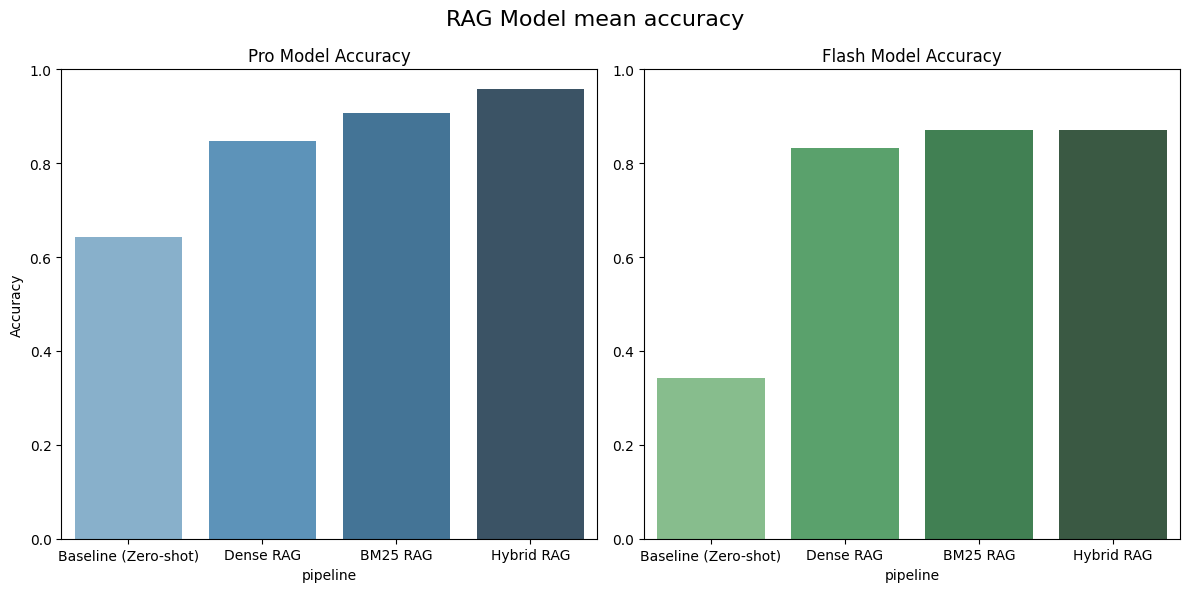

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Change to 1 Row, 2 Columns (and reduce width slightly)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('RAG Model mean accuracy', fontsize=16)

# --- CHART 1: PRO Model ---
sns.barplot(
    data=plot_data, 
    x="pipeline", 
    y="pro_acc", 
    hue="pipeline", 
    palette="Blues_d", 
    legend=False, 
    ax=axes[0]
)
axes[0].set_title("Pro Model Accuracy")
axes[0].set_ylim(0, 1.0)
axes[0].set_ylabel("Accuracy")

# --- CHART 2: FLASH Model ---
sns.barplot(
    data=plot_data, 
    x="pipeline", 
    y="flash_acc", 
    hue="pipeline", 
    palette="Greens_d", 
    legend=False, 
    ax=axes[1]
)
axes[1].set_title("Flash Model Accuracy")
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("") # Hide Y-label for the second chart to look cleaner

plt.tight_layout()
plt.show()

## Latency


In [10]:
import numpy as np
import matplotlib.pyplot as plt

pipelines = ["Baseline (Zero-shot)", "BM25 RAG", "Dense RAG", "Hybrid RAG"]
plot_data
# Linear bins from 0 to 250 seconds
bins = np.arange(0, 100, 5)  # 10-second intervals
plot_data["latency_bin"] = pd.cut(plot_data["latency"], bins=bins, include_lowest=True)

# Group and normalize per pipeline
binned = (
    plot_data
    .groupby(["pipeline", "latency_bin"], observed=False)
    .size()
    .reset_index(name="count")
)
totals = binned.groupby("pipeline")["count"].transform("sum")
binned["norm"] = binned["count"] / totals

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, p in zip(axes, pipelines):
    dfp = binned[binned["pipeline"] == p]
    ax.bar(dfp["latency_bin"].astype(str), dfp["norm"])
    ax.set_title(p)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, dfp["norm"].max() * 1.1)

axes[0].set_ylabel("Proportion")
fig.suptitle("Latency Distribution by Pipeline", fontsize=16)
plt.tight_layout()
plt.show()

KeyError: 'latency'

In [ ]:
summary = plot_data.groupby("pipeline")["latency"].agg(
    mean="mean",
    std="std"
)
summary

## Source attribution accuracy

Se obtiene un merged_df con las referencias en el paper y las citaciones de las diferentes LLMs.

In [ ]:
SAA_df = pd.read_csv(CSV_FILE)
SAA_df = SAA_df[SAA_df['pipeline'].isin(['BM25 RAG', 'Dense RAG', 'Hybrid RAG'])]
SAA_df = SAA_df.drop(columns=['predicted','ground_truth','latency','run_timestamp'])

with open("ModelizaciónEmpresaUCMData.json") as f:
    references = json.load(f)

ref_dict = {i + 1: item["paper_reference"] for i, item in enumerate(references)}

ref_df = pd.DataFrame.from_dict(ref_dict, orient='index', columns=['paper_reference'])
ref_df.index.name = 'question_number'
ref_df.reset_index(inplace=True)

merged_df = SAA_df.merge(ref_df, on='question_number', how='left')
merged_df.head()

### Fuzzscore
Luego se utilizará esta métrica para evaluar el dataset.

In [ ]:
from rapidfuzz import fuzz

def verify_quote_accuracy(retrieved_quote, source_text):
    """
    A robust check that handles both exact substrings and jumbled/reordered words.
    """
    # 1. Safety Checks
    if not retrieved_quote or pd.isna(retrieved_quote) or retrieved_quote in ["", "No quote provided"]:
        return 0
    if not source_text or pd.isna(source_text):
        return 0

    # 2. Pre-cleaning (lowercasing is usually enough for RapidFuzz)
    clean_quote = str(retrieved_quote).lower().strip()
    clean_source = str(source_text).lower().strip()
    
    # 3. Calculate Two Scores
    
    # Score A: Strict Order (What you were using)
    # Good for: Verbatim quotes.
    score_strict = fuzz.partial_ratio(clean_quote, clean_source)
    
    # Score B: Flexible Order (The fix)
    # Good for: "95% accuracy" matching "accuracy of 95%"
    # It tokenizes the strings, sorts them, and compares the intersection.
    score_flexible = fuzz.token_set_ratio(clean_quote, clean_source)
    
    # 4. Return the Best Score
    return max(score_strict, score_flexible)

merged_df['quote'] = merged_df['quote'].fillna(" ")

merged_df['fuzz_score'] = merged_df.apply(lambda row: verify_quote_accuracy(row['quote'], row['paper_reference']), axis=1)
merged_df.head()

#### Obtaining source atribution accuracy

Se utiliza una función presente en la clase Evaluator en main para obtener el SAA. Esta función opera así: se le proporciona el contexto de la página en donde se sitúa la referencia de la pregunta y luego se le pide que compare la citación dada por la LLM + (algún método de RAG) con la referencia y su entorno y que genere el SAA (faithfulness_score).

In [ ]:
import main 
from tqdm import tqdm
import google.generativeai as genai
from main import VectorStoreManager, Evaluator, DATASET_PATH

rag_results = merged_df.copy()

V = VectorStoreManager()
E = Evaluator(DATASET_PATH)

def get_source_text_for_evaluation(quote: str) -> str:
    # Handle cases where quote is None, NaN, or empty
    if not isinstance(quote, str) or not quote.strip(): 
        return ""
    
    clean_quote = quote.replace("\n", " ").strip()
    
    try:
        results = V.search(clean_quote, k=1)
        if results:
            return results[0].page_content
    except Exception as e:
        print(f"Search error: {e}")
        
    return ""

print("Retrieving source text...")
tqdm.pandas(desc="Retrieving Context")
rag_results['source_text_for_judge'] = rag_results['quote'].progress_apply(get_source_text_for_evaluation)

print("Evaluating attribution...")
tqdm.pandas(desc="Checking Faithfulness")

def check_faithfulness(row):

    if hasattr(E, 'source_atribution_accuracy'):
        score, reason = E.source_atribution_accuracy(row['quote'], row['source_text_for_judge'])
    else:
        return pd.Series([0.0, "Method not found in Evaluator class"])
        
    return pd.Series([score, reason])

# Apply and Save
rag_results[['faithfulness_score', 'faithfulness_reasoning']] = rag_results.progress_apply(check_faithfulness, axis=1)

# Display
rag_results.to_csv("Results.csv")
rag_results.head()

In [ ]:
rag_results['faithfulness_score'].mean()
rag_results.to_csv("SAA.csv",index=False)

In [ ]:
rag_results[rag_results['pipeline'] == 'Hybrid RAG']

### Source atribution accuracy representation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_data = rag_results.copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('RAG Model source atribution accuracy mean', fontsize=16)

# --- CHART 1: PRO Model ---
sns.barplot(
    data=plot_data, 
    x="pipeline", 
    y="faithfulness_score", 
    hue="pipeline", 
    palette="Blues_d", 
    errorbar=None,
    legend=False, 
    ax=axes[0]
)
axes[0].set_title("Pro Model SAA")
axes[0].set_ylim(0, 1.0)
axes[0].set_ylabel("SAA mean")

# --- CHART 2: FLASH Model ---
sns.barplot(
    data=plot_data, 
    x="pipeline", 
    y="faithfulness_score", 
    hue="pipeline", 
    palette="Greens_d", 
    legend=False,
    errorbar=None,
    ax=axes[1]
)
axes[1].set_title("Flash Model SAA")
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("") # Hide Y-label for the second chart to look cleaner

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

pipelines = ["BM25 RAG", "Dense RAG", "Hybrid RAG"]

bins = np.arange(0, 1.0001, 0.05)
plot_data["bin"] = pd.cut(plot_data["faithfulness_score"], bins=bins, include_lowest=True)

# Raw counts
binned = (
    plot_data
    .groupby(["pipeline", "bin"], observed=False)
    .size()
    .reset_index(name="count")
)

# Normalize within each pipeline
totals = binned.groupby("pipeline")["count"].transform("sum")
binned["norm"] = binned["count"] / totals   # proportions

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

for ax, p in zip(axes, pipelines):
    dfp = binned[binned["pipeline"] == p]
    ax.bar(dfp["bin"].astype(str), dfp["norm"])
    ax.set_title(p)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, dfp["norm"].max() * 1.1)
    
fig.suptitle("SAA Distribution by Pipeline", fontsize=16)
axes[0].set_ylabel("Proportion")
plt.tight_layout()
plt.show()

Nota: Los gráficos están normalizados

In [ ]:
import numpy as np

pipelines = ["BM25 RAG", "Dense RAG", "Hybrid RAG"]

bins = np.arange(0.001, 1.000, 0.05)
plot_data["bin"] = pd.cut(plot_data["faithfulness_score"], bins=bins, include_lowest=True)

binned = (
    plot_data
    .groupby(["pipeline", "bin"], observed=False)
    .size()
    .reset_index(name="count")
)

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

for ax, p in zip(axes, pipelines):
    dfp = binned[binned["pipeline"] == p]
    ax.bar(dfp["bin"].astype(str), dfp["count"])
    ax.set_title(p)
    ax.tick_params(axis='x', rotation=90)

axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()

##### Nota

La representación gráfica está normalizada para si se para la ejecución del main y por ejemplo tenemos menos casos para hybrid RAG que para dense RAG en el .csv original, las gráficas sigan representando la source atribution accuracy que deberían.